# 2. Streaming application using Spark Structured Streaming
1. SparkSession is created using a SparkConf object, which would use two local cores with a proper application name, and use UTC as the timezone

In [1]:
# Reference taken from labs
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'

from pyspark import SparkConf
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# local[2]: run Spark in local mode with as 2 working processors 
master = "local[2]"
# Set the appname
app_name = "Spark Streaming"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set("spark.sql.session.timeZone", "UTC")
print(spark_conf.toDebugString())

# Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

spark.master=local[2]
spark.app.name=Assignment 2B - Task 2 Spark Streaming
spark.sql.session.timeZone=UTC


Define the data schema for the sensor location CSV file

In [2]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

# define schema
sensor_location_schema = StructType([StructField("sensor_id",IntegerType(),False), 
                                   StructField("sensor_description", StringType(),False), 
                                   StructField("sensor_name", StringType(),True), 
                                   StructField("installation_date", DateType(),True), 
                                   StructField("status", StringType(),True), 
                                   StructField("note", StringType(),True), 
                                   StructField("direction_1", StringType(),True),
                                   StructField("direction_2", StringType(),True),
                                   StructField("latitude", IntegerType(),True),
                                   StructField("longitude", IntegerType(),True),
                                   StructField("location", StringType(), True)])


# function to read csv into df with a given schema
def readCsvToDf(filename:str, schema):
    df = spark.read.format("csv").option("header", "true").schema(schema).load(filename)
    df.printSchema()
    return df

# load pedestrian count CSV file into a dataframe
sensor_location_df = readCsvToDf("Pedestrian_Counting_System_-_Sensor_Locations.csv", sensor_location_schema)

root
 |-- sensor_id: integer (nullable = true)
 |-- sensor_description: string (nullable = true)
 |-- sensor_name: string (nullable = true)
 |-- installation_date: date (nullable = true)
 |-- status: string (nullable = true)
 |-- note: string (nullable = true)
 |-- direction_1: string (nullable = true)
 |-- direction_2: string (nullable = true)
 |-- latitude: integer (nullable = true)
 |-- longitude: integer (nullable = true)
 |-- location: string (nullable = true)



Ingest the streaming data into Spark Streaming assuming all data coming in String format

In [52]:
topic = "pedestrian_count"

# Read the streaming data with the topic 'pedestrian_count'
streamed_df = spark \
                .readStream \
                .format("kafka") \
                .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
                .option("subscribe", topic) \
                .load()

# Select only the key and values of the streaming df data and cast them as strings instead of binary
streamed_df = streamed_df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

# defining the pedestrian counts data schema
temporary_ped_count_schema = StructType([StructField("ID",StringType(),False), 
                                   StructField("Date_Time", StringType(),False), 
                                   StructField("Year", StringType(),True), 
                                   StructField("Month", StringType(),True), 
                                   StructField("Mdate", StringType(),True), 
                                   StructField("Day", StringType(),True), 
                                   StructField("Time", StringType(),True),
                                   StructField("Sensor_ID", StringType(),True),
                                   StructField("Sensor_Name", StringType(),True),
                                   StructField("Hourly_Counts", StringType(),True)])

# select only the value column and get all its subvalues into the schema
parsed_ped_count_df=streamed_df.select(from_json(col("value").cast("string"), temporary_ped_count_schema).alias('parsed_value'))

# function to ge the subvalues from the value of the streamed data
def get_subvalues_from_value(df):
    df_formatted = df.select(
                        col("parsed_value.ID").alias("ID"),
                        col("parsed_value.Date_Time").alias("Date_Time"),
                        col("parsed_value.Year").alias("Year"),
                        col("parsed_value.Month").alias("Month"),
                        col("parsed_value.Mdate").alias("Mdate"),
                        col("parsed_value.Day").alias("Day"),
                        col("parsed_value.Time").alias("Time"),
                        col("parsed_value.Sensor_ID").alias("Sensor_ID"),
                        col("parsed_value.Sensor_Name").alias("Sensor_Name"),
                        col("parsed_value.Hourly_Counts").alias("Hourly_Counts"),
                    )
    
    return df_formatted

# get the subvalues from the value header
df_formatted = get_subvalues_from_value(parsed_ped_count_df)

df_formatted.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Date_Time: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Sensor_ID: string (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: string (nullable = true)



Create the output sink for the stream by viewing the output in the console   

In [19]:
query = df_formatted \
    .writeStream \
    .outputMode("append") \
    .format("console") \
    .trigger(processingTime='5 seconds') \
    .start()

In [85]:
query.stop()

Console Output:
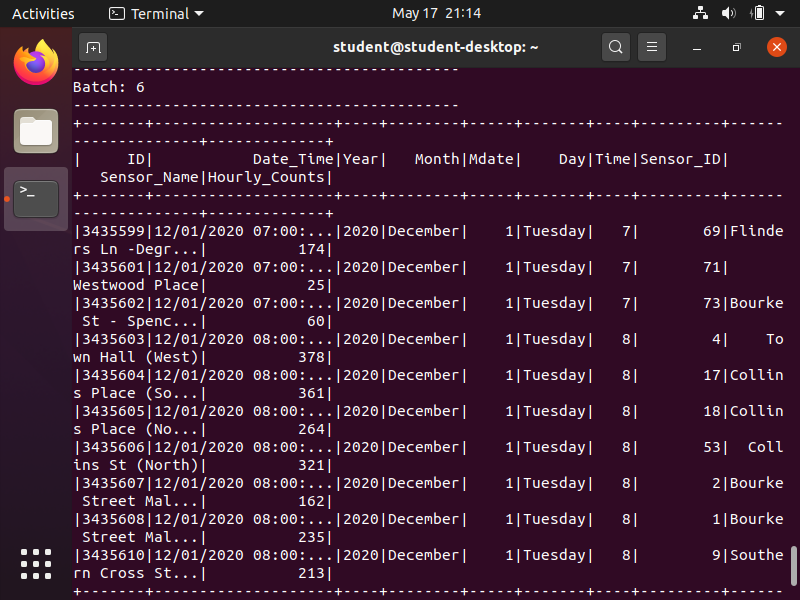

5. Then the streaming data format should be transformed into the proper formats 

In [32]:
# select only the value column and get all its subvalues into the schema
pedestrian_count_df=streamed_df.select(from_json(col("value"), temporary_ped_count_schema).alias('parsed_value'))

# get the subvalues from the value
pedestrian_count_df = get_subvalues_from_value(pedestrian_count_df)

# convert the values into their appropriate values
pedestrian_count_df = pedestrian_count_df.withColumn("ID", pedestrian_count_df["ID"].cast(IntegerType()))
pedestrian_count_df = pedestrian_count_df.withColumn("Date_Time",to_timestamp(col("Date_Time"), "MM/dd/yyyy hh:mm:ss a").alias("Date_Time"))
pedestrian_count_df = pedestrian_count_df.withColumn("Year", pedestrian_count_df["Year"].cast(IntegerType()))
pedestrian_count_df = pedestrian_count_df.withColumn("Mdate", pedestrian_count_df["Mdate"].cast(IntegerType()))
pedestrian_count_df = pedestrian_count_df.withColumn("Time", pedestrian_count_df["Time"].cast(IntegerType()))
pedestrian_count_df = pedestrian_count_df.withColumn("Sensor_ID", pedestrian_count_df["Sensor_ID"].cast(IntegerType()))
pedestrian_count_df = pedestrian_count_df.withColumn("Hourly_Counts", pedestrian_count_df["Hourly_Counts"].cast(IntegerType()))

pedestrian_count_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Date_Time: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)



6. Prepare to predict the next day’s pedestrian count, perform the following transformations to prepare the columns for model prediction.  

In [33]:
# create a UDF to convert the dayofweek result from Sunday being 1 to Monday being 1
def weekday(s):
    if s==1:
        return 7
    elif s==2:
        return 1
    elif s==3:
        return 2
    elif s==4:
        return 3
    elif s==5:
        return 4
    elif s==6:
        return 5
    else:
        return 6

weekday_udf = udf(weekday,IntegerType())

# Add the columns
new_ped_count_df = pedestrian_count_df.withColumn('next_date', date_add(pedestrian_count_df['Date_Time'], 1))

new_ped_count_df = new_ped_count_df.withColumn('next_Mdate', dayofmonth("next_date"))

new_ped_count_df = new_ped_count_df.withColumn('next_day_week', weekofyear("next_date"))

new_ped_count_df = new_ped_count_df.withColumn('next_day_of_week', weekday_udf(dayofweek("next_date")))

new_ped_count_df = new_ped_count_df.withColumnRenamed('Hourly_Counts', 'prev_count')

new_ped_count_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Date_Time: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- prev_count: integer (nullable = true)
 |-- next_date: date (nullable = true)
 |-- next_Mdate: integer (nullable = true)
 |-- next_day_week: integer (nullable = true)
 |-- next_day_of_week: integer (nullable = true)



7. Load the machine learning models given, and use the model to predict the next day’s pedestrian count between 0am-11.59pm.  
a. View the prediction output in the console for every 5 seconds (with trigger interval of 5 seconds)  
b. Select columns of 'Sensor_ID', 'Date_Time', 'next_date' and 'prediction' as output for viewing.  
c. Take a screenshot of output in the console

In [79]:
# # Extracting the model file from the zip file

# import zipfile as zf
# files = zf.ZipFile("count_estimation_pipeline_model.zip", 'r')
# files.extractall()
# files.close()

In [13]:
from pyspark.ml import PipelineModel

#Loading the Pipeline Model From the filesystem
pipelineModel = PipelineModel.load('count_estimation_pipeline_model')

In [34]:
# Get the predictions using the imported model based on the pedestrian count dataframe
prediction_df = pipelineModel.transform(new_ped_count_df)
prediction_df = prediction_df.select('Sensor_ID', 'Date_Time', 'next_date','prediction')

In [35]:
# run the query on the console
prediction_query = prediction_df \
                .writeStream \
                .outputMode("append") \
                .format("console") \
                .trigger(processingTime='5 seconds') \
                .start()

In [36]:
prediction_query.stop()

Predicted Output in Console:
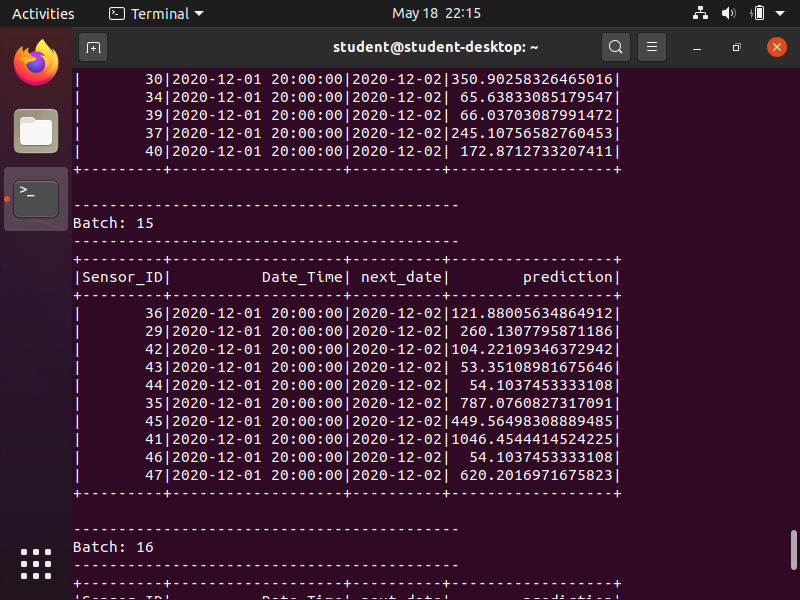

8. Using the prediction result, and write code to process the data following the requirement below  
a. For each sensor, get the number of hours that the predicted pedestrian count would exceed 1000 on each day (for the hours between 0am-11.59pm).    
  i. Combine the result with sensor longitude and latitude information   
  ii. View the count for each sensor (with location information) in the console for every 5 seconds    

In [49]:
# Filter away those less than 1000, group by sensor id and day then count the number of times the count exceeds 1000 each day
grouped_df = prediction_df.filter(prediction_df['prediction'] > 1000).groupBy('Sensor_ID', window('next_date', '1 day')).count()

# Join with the other dataframe to get the longitude and latitude
joined_df = grouped_df.alias('g_df').join(sensor_location_df.alias('s_df'), col('s_df.sensor_id') == col('g_df.Sensor_ID'), 'inner').select('g_df.Sensor_ID', 'location','window', 'count')

In [50]:
# run the query on the console
count_query = joined_df \
                .writeStream \
                .outputMode("complete") \
                .format("console") \
                .trigger(processingTime='5 seconds') \
                .option("truncate", False) \
                .start()

In [51]:
count_query.stop()

## Predicted pedestrian count that exceeds 1000 on each day, console output:  
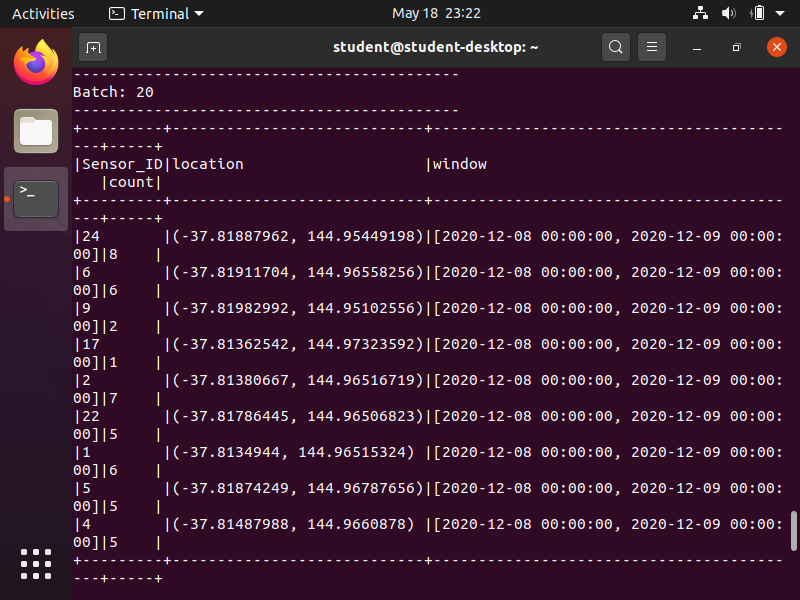